In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from xgboost import XGBClassifier

<h1>데이터셋 불러오기

In [3]:
# 첫 번째 열(인덱스) 제거 후 불러옴
df = pd.read_csv('dataset.csv', index_col=0)

In [4]:
# 컬럼 확인
df.columns

Index(['having_IPhaving_IP_Address', 'URLURL_Length', 'Shortining_Service',
       'having_At_Symbol', 'double_slash_redirecting', 'Prefix_Suffix',
       'having_Sub_Domain', 'SSLfinal_State', 'Domain_registeration_length',
       'Favicon', 'port', 'HTTPS_token', 'Request_URL', 'URL_of_Anchor',
       'Links_in_tags', 'SFH', 'Submitting_to_email', 'Abnormal_URL',
       'Redirect', 'on_mouseover', 'RightClick', 'popUpWidnow', 'Iframe',
       'age_of_domain', 'DNSRecord', 'web_traffic', 'Page_Rank',
       'Google_Index', 'Links_pointing_to_page', 'Statistical_report',
       'Result'],
      dtype='object')

In [5]:
# 데이터 정보 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11055 entries, 1 to 11055
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   having_IPhaving_IP_Address   11055 non-null  int64
 1   URLURL_Length                11055 non-null  int64
 2   Shortining_Service           11055 non-null  int64
 3   having_At_Symbol             11055 non-null  int64
 4   double_slash_redirecting     11055 non-null  int64
 5   Prefix_Suffix                11055 non-null  int64
 6   having_Sub_Domain            11055 non-null  int64
 7   SSLfinal_State               11055 non-null  int64
 8   Domain_registeration_length  11055 non-null  int64
 9   Favicon                      11055 non-null  int64
 10  port                         11055 non-null  int64
 11  HTTPS_token                  11055 non-null  int64
 12  Request_URL                  11055 non-null  int64
 13  URL_of_Anchor                11055 non-null  int64


In [6]:
# 데이터 크기 확인
df.shape

(11055, 31)

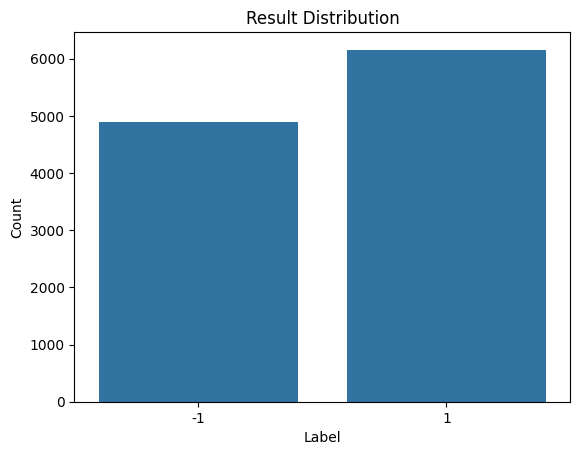

In [7]:
sns.countplot(x='Result', data=df)
plt.title('Result Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

<h1> 데이터 분할

In [8]:
X = df.drop(columns=['Result']) # 'Result' 열은 phising/legitimate 데이터 가지고 있음
y = df['Result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<h1> 모델 객체 생성

In [9]:
xgb = XGBClassifier(
    objective='binary:logistic',
    learning_rate=0.4,
    max_depth=7,

    )

In [10]:
# 타겟 값 변환 (-1을 0으로 변환)
# XGBoost 모델이 기대하는 형식[0 1]과 맞춤
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

In [11]:
# 변환 후 고유 값 및 빈도 확인
print("변환 후 y_train 고유 값:", pd.Series(y_train).unique())
print("변환 후 y_train 유일한 값 개수:\n", pd.Series(y_train).value_counts())
print()
print("변환 후 y_test 고유 값:", pd.Series(y_test).unique())
print("변환 후 y_test 유일한 값 개수:\n", pd.Series(y_test).value_counts())

변환 후 y_train 고유 값: [1 0]
변환 후 y_train 유일한 값 개수:
 Result
1    4902
0    3942
Name: count, dtype: int64

변환 후 y_test 고유 값: [0 1]
변환 후 y_test 유일한 값 개수:
 Result
1    1255
0     956
Name: count, dtype: int64


<h1> 모델 학습

In [12]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

<h1> 모델 평가

In [13]:
# 일반화 성능 평가용
y_test_pred = xgb.predict(X_test)

# 과적합 여부 확인
y_train_pred = xgb.predict(X_train)

In [14]:
# 검증 정확도 계산
acc_test = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {acc_test}")

# 훈련 정확도 계산
acc_train = accuracy_score(y_train, y_train_pred)
print(f"Train Accuracy: {acc_train}")

Test Accuracy: 0.9706015377657169
Train Accuracy: 0.9889190411578471


<h1>분류 보고서

In [15]:
# 테스트셋 분류 보고서
test_report = classification_report(y_test, y_test_pred, target_names=['-1', '1'])
print("Test Classification Report:")
print(test_report)

Test Classification Report:
              precision    recall  f1-score   support

          -1       0.98      0.95      0.97       956
           1       0.96      0.98      0.97      1255

    accuracy                           0.97      2211
   macro avg       0.97      0.97      0.97      2211
weighted avg       0.97      0.97      0.97      2211



In [16]:
# 훈련셋 분류 보고서
train_report = classification_report(y_train, y_train_pred, target_names=['-1', '1'])
print("Train Classification Report:")
print(train_report)

Train Classification Report:
              precision    recall  f1-score   support

          -1       0.99      0.99      0.99      3942
           1       0.99      0.99      0.99      4902

    accuracy                           0.99      8844
   macro avg       0.99      0.99      0.99      8844
weighted avg       0.99      0.99      0.99      8844



<h1>혼동 행렬

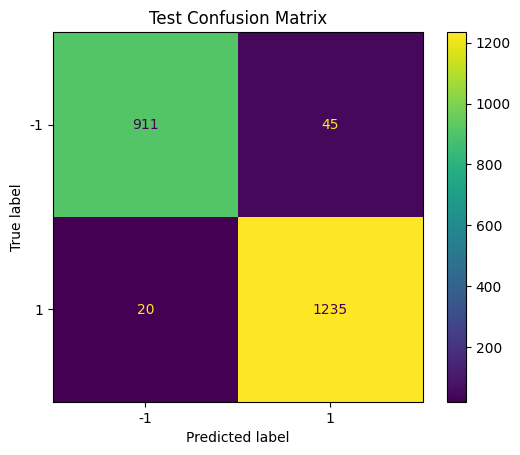

In [17]:
# 테스트 데이터 혼동 행렬
test_conf_matrix = confusion_matrix(y_test, y_test_pred, labels=[0, 1])

disp_test = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=[-1, 1])
disp_test.plot()
plt.title('Test Confusion Matrix')
plt.show()

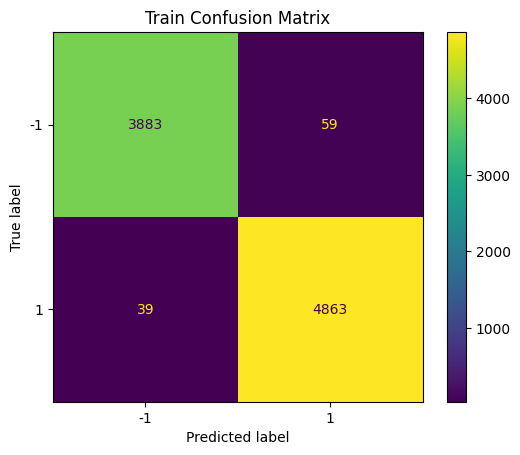

In [18]:
# 훈련 데이터 혼동 행렬
train_conf_matrix = confusion_matrix(y_train, y_train_pred, labels=[0, 1])

disp_train = ConfusionMatrixDisplay(confusion_matrix=train_conf_matrix, display_labels=[-1, 1])
disp_train.plot()
plt.title('Train Confusion Matrix')
plt.show()

<h1>교차 검증

In [19]:
# 5-fold 교차 검증 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_val_score(xgb, X_train, y_train, cv=kf, scoring='accuracy')

# 교차 검증 결과 출력
for i, score in enumerate(cv_results):
    print(f"교차 검증 {i} 정확도: {score:.4f}")

# 평균 정확도 출력
mean_cv_score = cv_results.mean()
print(f"평균 정확도: {mean_cv_score:.4f}")

교차 검증 0 정확도: 0.9751
교차 검증 1 정확도: 0.9661
교차 검증 2 정확도: 0.9740
교차 검증 3 정확도: 0.9740
교차 검증 4 정확도: 0.9712
평균 정확도: 0.9721
